### Available connectomes in Conn2Res
 - Dorsal Attention (DA)
 - Default Mode Network (DMN)
 - Frontoparietal (FP)
 - Limbic (LIM)
 - Somatomotor (SM)
 - Ventral Attention (VA)
 - Visual (VIS)

References available via [Zenodo repository](https://zenodo.org/records/10205004)

Sources:
 - [Suarez et al., 2020](https://www.biorxiv.org/content/10.1101/2020.11.10.350876v1.full.pdf)
 - [Dong et al., 2024](https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.26575)

In [1]:
# Do the same narrative event segmentation but with a conn2res model instead of a reservoir
# This is a reservoir that utilizes specific connectivity
%matplotlib inline
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

import warnings
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import is_classifier
from conn2res.tasks import Task, NeuroGymTask
from conn2res.connectivity import Conn
from conn2res.reservoir import EchoStateNetwork
from conn2res.readout import Readout
from conn2res import readout, plotting
from tqdm import tqdm
import reservoirpy as rpy
import matplotlib.patches as patches

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
# Need to build task, which is the Narrative event segmentation task using the wikipedia2vec embeddings of narrative

# set up

from wikipedia2vec import Wikipedia2Vec
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# np.random.seed(4)
vectorDim = 100

numNode = 500


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ijackson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# get training data and task
in_small = '/home/ijackson/dynamics/sandbox/Narrative-Integration-Reservoir/in_small.npy'
out_small = '/home/ijackson/dynamics/sandbox/Narrative-Integration-Reservoir/out_small.npy'
wiki2vec = Wikipedia2Vec.load('/home/ijackson/dynamics/sandbox/enwiki_20180420_100d.pkl')

#read in the narrative

huge_list = []

#with open("my_file_Gatsby_Kane_wolfe_bond.txt", "r") as f:
#    huge_list = f.read().split()::::"iss_gatsby_long.txt"
#with open("iss_gatsby_nfl_long.txt", "r", encoding="utf8") as f:
with open("/home/ijackson/dynamics/sandbox/Narrative-Integration-Reservoir/not-the-fall.txt", "r", encoding="utf8") as f:
    huge_list = f.read().split()

discourse_words = huge_list

# need to train reservoir on this data

In [5]:
# clean it up
# large capital -> small capital

discourse_words = [s.replace(s, s.lower()) for s in discourse_words]

    # remove '.' and ',' from word list
discourse_words = [s.replace('.', '') for s in discourse_words]
discourse_words = [s.replace(',', '') for s in discourse_words]

    # remove stop words from word list
stop_words = stopwords.words('english')
    #print(stop_words)
for stop_word in tqdm(stop_words):
    while stop_word in discourse_words :
        discourse_words.remove(stop_word)
            
    # remove "'s" and "'" and "-" and "'d" and "'ll" and "'ve" and "re" from word list
discourse_words = [s.replace("'s", '') for s in discourse_words]
discourse_words = [s.replace("'", '') for s in discourse_words]
discourse_words = [s.replace("-", ' ') for s in discourse_words]
discourse_words = [s.replace("'d", '') for s in discourse_words]
discourse_words = [s.replace("'ll", '') for s in discourse_words]
discourse_words = [s.replace("'ve", '') for s in discourse_words]
discourse_words = [s.replace("'re", '') for s in discourse_words]
discourse_words = [s.replace("(", '') for s in discourse_words]
discourse_words = [s.replace(")", '') for s in discourse_words]
discourse_words = [s.replace("[", '') for s in discourse_words]
discourse_words = [s.replace("]", '') for s in discourse_words]
discourse_words = [s.replace(",", '') for s in discourse_words]
discourse_words = [s.replace(";", '') for s in discourse_words]
discourse_words = [s.replace("-", '') for s in discourse_words]
discourse_words = [s.replace(":", '') for s in discourse_words]
discourse_words = [s.replace("?", '') for s in discourse_words]
discourse_words = [s.replace("!", '') for s in discourse_words]


100%|██████████| 179/179 [00:00<00:00, 15541.21it/s]


In [6]:
inputDataTesting = np.empty((0,vectorDim))
print(inputDataTesting.shape)

for num in range(len(discourse_words)):
    inputDataTesting = np.append(inputDataTesting, np.array([wiki2vec.get_word_vector(discourse_words[num])]), axis=0)
    # print(discourse_words[num], num, end = ' ')
print('\n'+str(inputDataTesting.shape))

(0, 100)

(682, 100)


In [7]:
consensus_0 = np.load('/home/ijackson/dynamics/conn2res/examples/data/human/consensus_0.npy')
consensus_1 = np.load('/home/ijackson/dynamics/conn2res/examples/data/human/consensus_1.npy')
consensus_2 = np.load('/home/ijackson/dynamics/conn2res/examples/data/human/consensus_2.npy')
consensus_3 = np.load('/home/ijackson/dynamics/conn2res/examples/data/human/consensus_3.npy')
consensus_4 = np.load('/home/ijackson/dynamics/conn2res/examples/data/human/consensus_4.npy')
consensus_5 = np.load('/home/ijackson/dynamics/conn2res/examples/data/human/consensus_5.npy')
coords = np.load('/home/ijackson/dynamics/conn2res/examples/data/human/coords.npy') # coordinates for each node
cortical = np.load('/home/ijackson/dynamics/conn2res/examples/data/human/cortical.npy') # a 0 or 1 for each node indicating cortical or subcortical?
hemiid = np.load('/home/ijackson/dynamics/conn2res/examples/data/human/hemiid.npy') # a 0 or 1 for each node indicating hemisphere
rsn_mapping = np.load('/home/ijackson/dynamics/conn2res/examples/data/human/rsn_mapping.npy') # network assignment for each node
connectivity = np.load('/home/ijackson/dynamics/conn2res/examples/data/human/connectivity.npy') # connectivity matrix for 70 subjects

print("Shape of consensus_0: ", consensus_0.shape)
print("Shape of consensus_1: ", consensus_1.shape)
print("Shape of consensus_2: ", consensus_2.shape)
print("Shape of consensus_3: ", consensus_3.shape)
print("Shape of consensus_4: ", consensus_4.shape)
print("Shape of consensus_5: ", consensus_5.shape)
print("Shape of coords: ", coords.shape)
print("Shape of cortical: ", cortical.shape)
print("Shape of hemiid: ", hemiid.shape)
print("Shape of rsn_mapping: ", rsn_mapping.shape)
print("Shape of connectivity: ", connectivity.shape)

Shape of consensus_0:  (1015, 1015)
Shape of consensus_1:  (1015, 1015)
Shape of consensus_2:  (1015, 1015)
Shape of consensus_3:  (1015, 1015)
Shape of consensus_4:  (1015, 1015)
Shape of consensus_5:  (1015, 1015)
Shape of coords:  (1015, 3)
Shape of cortical:  (1015,)
Shape of hemiid:  (1015,)
Shape of rsn_mapping:  (1015,)
Shape of connectivity:  (1015, 1015, 70)


In [76]:
# load connectivity data of one subject
connectivity_path = '../../../conn2res/examples/data/human/connectivity.npy'
conn = Conn(filename=connectivity_path, subj_id=0)

# scale conenctivity weights between [0,1] and normalize by spectral radius
conn.scale_and_normalize() # this makes the spectral radius 1, which we can modify with alpha later

# get path of network labels for each node
nodes_path = '../../../conn2res/examples/data/human/rsn_mapping.npy'

# Init reservoirs with networks from Conn2Res
networks = {"DA":"Dorsal Attention","DMN":"Default Mode Network","FP":"Frontoparietal","LIM":"Limbic","SM":"Somatomotor","VA":"Ventral Attention","VIS":"Visual"}
vectorDim = 100
seed = 1
lr = 0.05
sr = 0.9
input_connectivity = 0.3
activation = 'tanh'
Win_random_weight = True
rpy.verbosity(0)
rpy.set_seed(42)
# get the connectivity matrix (w) for each network
# and make an input matrix (w_in) that maps from the input to the network
# then pass these into reservoirpy
reservoirs = {network: None for network in networks}
for network in networks:
    nodes = conn.get_nodes(network,filename=nodes_path)
    W = conn.w[np.ix_(nodes,nodes)]
    nNodes = W.shape[0]
    if Win_random_weight:
        Win = np.random.rand(nNodes, vectorDim) - 0.5
    else:
        Win = np.ones((nNodes, vectorDim))
    # we might want to make this a sparse matrix
    res = rpy.nodes.Reservoir(lr=lr, sr=sr, W=W, Win=Win, input_connectivity=input_connectivity,
                            seed=seed, activation=activation)
    reservoirs[network] = res
    
reservoirs["Base"] = rpy.nodes.Reservoir(vectorDim, lr=lr, sr=sr, seed=seed, input_connectivity=input_connectivity, activation=activation)

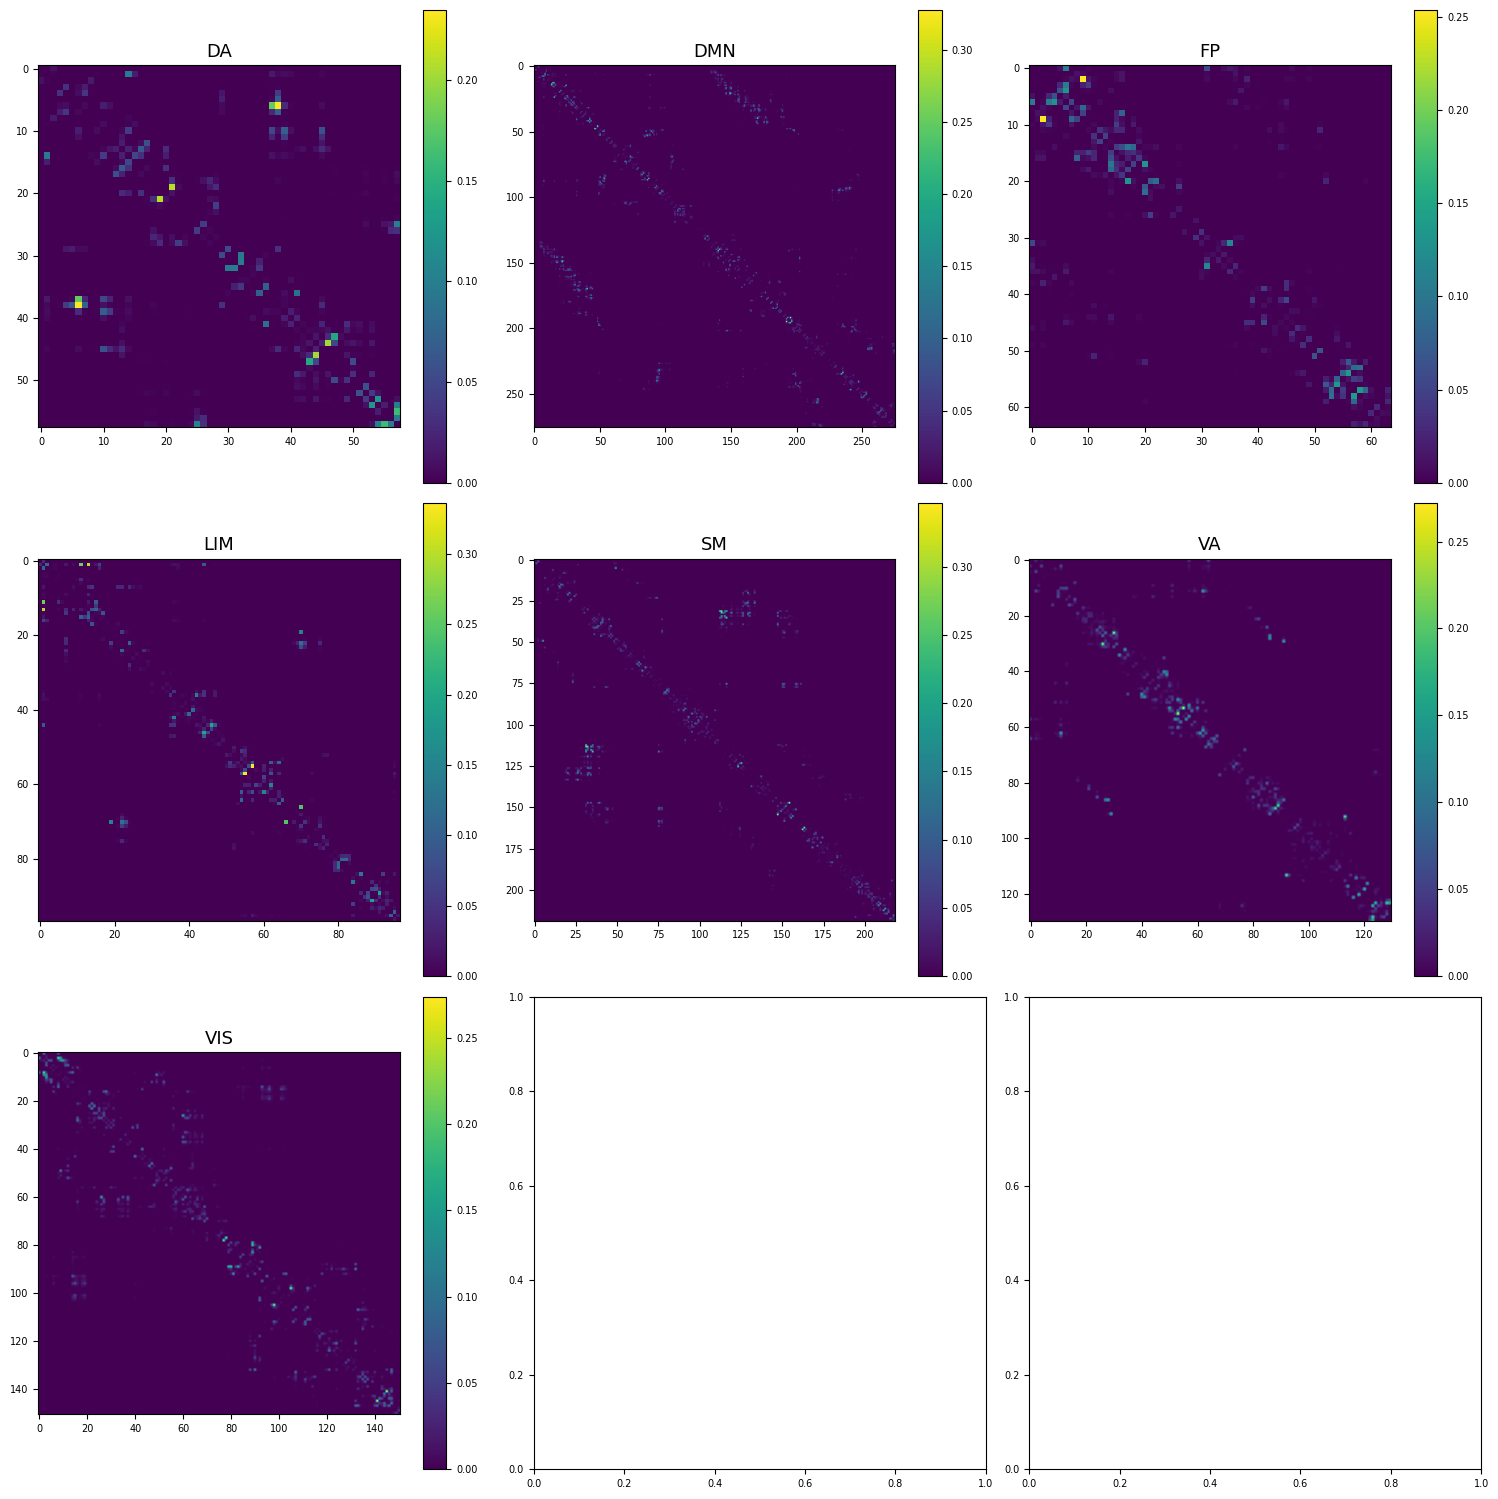

In [77]:
# Plot the connectivity matrix for each network

# 15 subctx regions in rsn_mapping but they don't show up in the connectivity matrix and there are none in any of the networks

# plot connectivity matrix in a 3x3 subplots for each network
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, network in enumerate(networks):
    try:
        nodes = conn.get_nodes(network,filename=nodes_path)
    except:
        print(f"Network {network} not found in the connectivity matrix")
    in_network_connectivity = conn.w[np.ix_(nodes,nodes)]
    plt.subplot(3,3,i+1)
    plt.imshow(in_network_connectivity)
    plt.title(network, fontsize=13)
    plt.colorbar()

#plt.suptitle("Connectivity for Each Network in Conn2Res", fontsize=13)
# add a little spacing between title and subplots
#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.tight_layout()
plt.show()

In [78]:
# Collect states from reservoirs
res_states = {network: None for network in networks}
# get reservoir states for each brain state
# reset = True
for network in networks:
    res = reservoirs[network]
    res_states[network] = res.run(inputDataTesting)
res_states["Base"] = np.load('../../reservoirStatesBuffer.npy') # import states from original NIR code

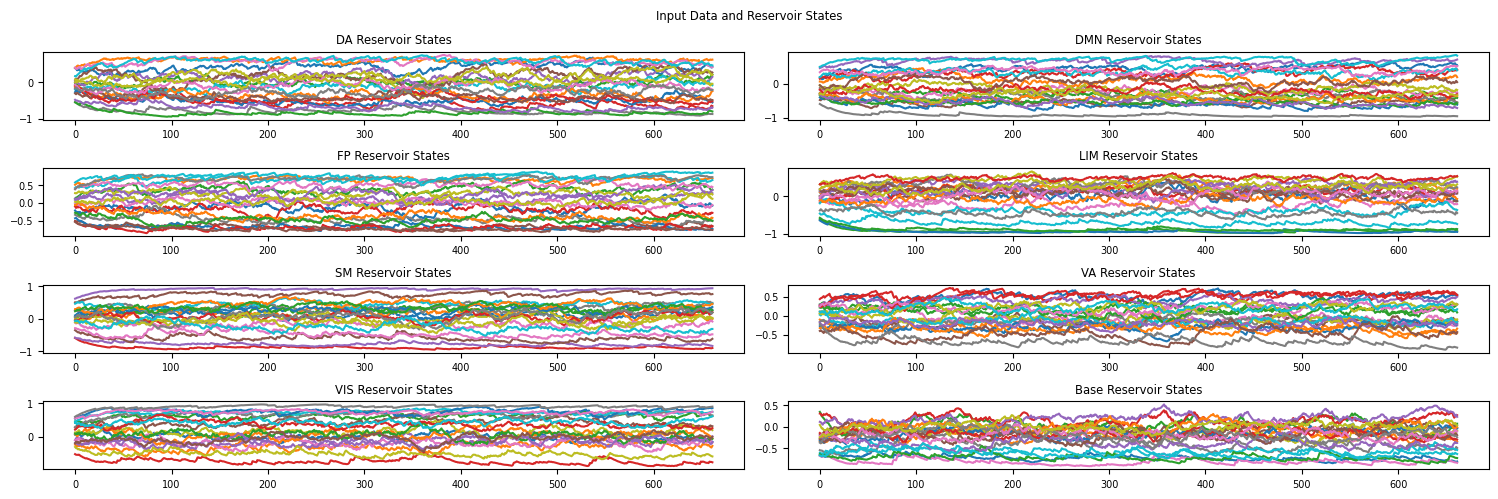

In [79]:
# plot the reservoir states against the input data states side by side
resn = 20
begin = 20
end = 682

fig = plt.figure(figsize=(15, 5))

for i, network in enumerate(res_states):
    plt.subplot(4,2,i+1)
    plt.plot(res_states[network][begin:end,:resn])
    plt.title(network + ' Reservoir States')

plt.suptitle("Input Data and Reservoir States")
fig.tight_layout()
plt.show()


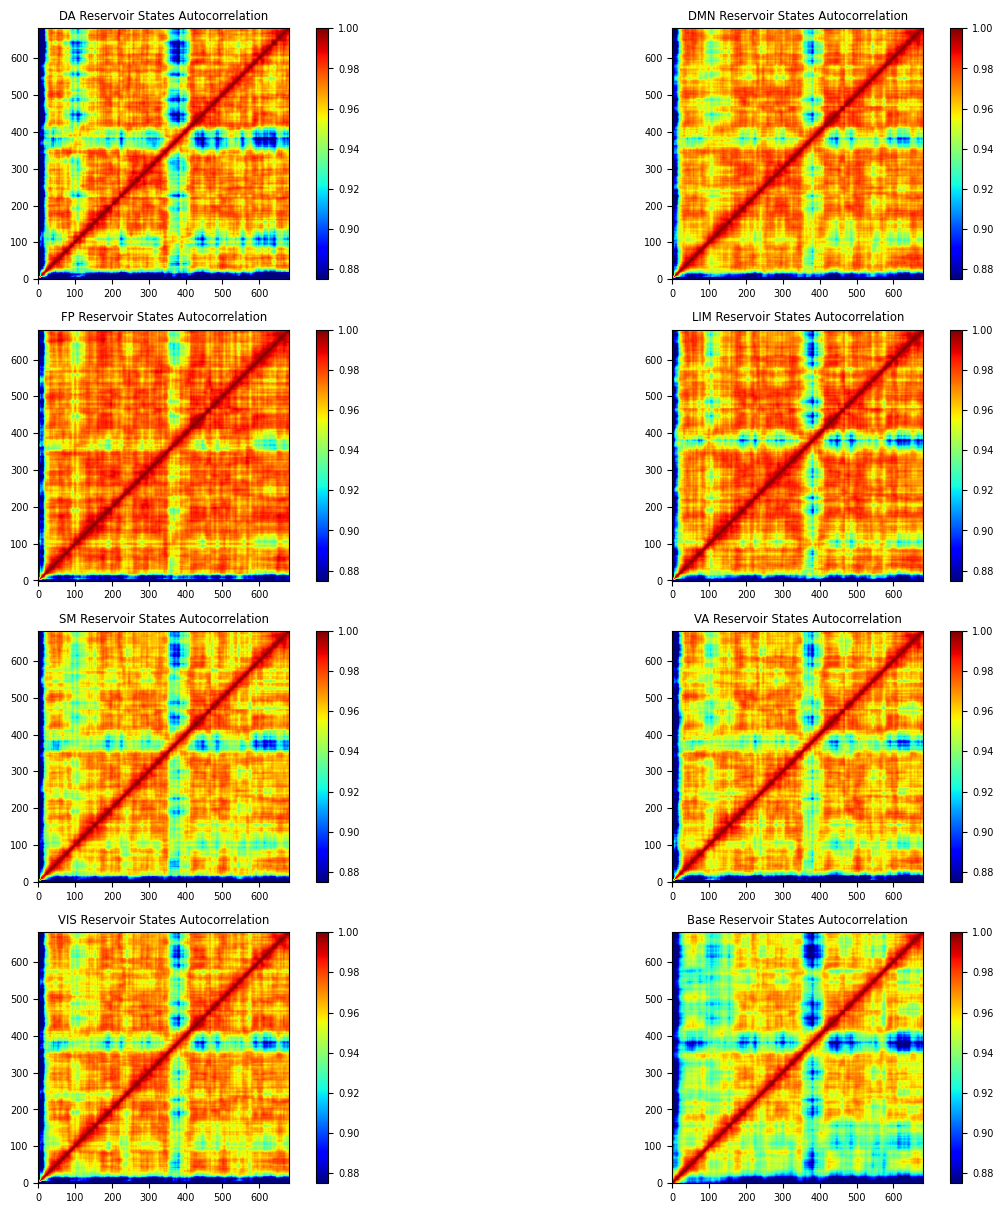

In [83]:
fig = plt.figure(figsize=(15,15))

for i, network in enumerate(res_states):
    plt.subplot(4,2,i+1)
    plt.imshow(np.corrcoef(res_states[network]), cmap='jet', origin='lower', vmin=0.875, vmax=1)
    plt.colorbar()
    plt.title(network + ' Reservoir States Autocorrelation')

# fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=fig.get_axes(), orientation='horizontal', fraction = 0.05, pad = 0.1)
# cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=fig.get_axes(), orientation='horizontal', location='bottom', boundaries=[0.875, 1])
# cbar.boundaries = [0.875, 1]

plt.tight_layout(rect=[1,0.1,1,1])

# plt.savefig('reservoir-states-autocorr.png',dpi=600)

In [ ]:
'''Questions

5. How to control the criticality mentioned in Suarez et al., 2020?
6. What's next?
 - Segment states
 - Look at context construction and forgetting
 - Look at alignment times
'''

"Questions\n\n2. Why is the autocorrelation of the input data so low?\n3. Does taking the states of esn.predict actually use any of the training from esn.fit in EasyESN?\n4. Some networks don't have enough nodes for inputs from Wikipedia2Vec embeddings. How do we handle this?\n5. How to control the criticality mentioned in Suarez et al., 2020?\n6. What's next?\n - Segment states\n - Look at context construction and forgetting\n - Look at alignment times\n"

In [84]:
# segment the states with the HMM from Baldassano (2017)
import brainiak.eventseg.event
nEvents = 12
nTR = 682
bounds_per_network = {network: None for network in res_states}
for network in tqdm(res_states):
    print(f"Segmenting states for network {network}")
    # 12 is the number of events for NTF, according to source github repo
    ev = brainiak.eventseg.event.EventSegment(nEvents)
    ev.fit(res_states[network])
    bounds = np.where(np.diff(np.argmax(ev.segments_[0], axis=1)))[0]
    bounds_aug = np.concatenate(([0],bounds,[nTR]))
    bounds_per_network[network] = bounds_aug


  0%|          | 0/8 [00:00<?, ?it/s]

Segmenting states for network DA


 12%|█▎        | 1/8 [00:02<00:18,  2.58s/it]

Segmenting states for network DMN


 25%|██▌       | 2/8 [00:05<00:16,  2.73s/it]

Segmenting states for network FP


 38%|███▊      | 3/8 [00:07<00:13,  2.61s/it]

Segmenting states for network LIM


 50%|█████     | 4/8 [00:10<00:10,  2.63s/it]

Segmenting states for network SM


 62%|██████▎   | 5/8 [00:13<00:08,  2.68s/it]

Segmenting states for network VA


 75%|███████▌  | 6/8 [00:15<00:05,  2.65s/it]

Segmenting states for network VIS


 88%|████████▊ | 7/8 [00:18<00:02,  2.65s/it]

Segmenting states for network Base


100%|██████████| 8/8 [00:21<00:00,  2.73s/it]


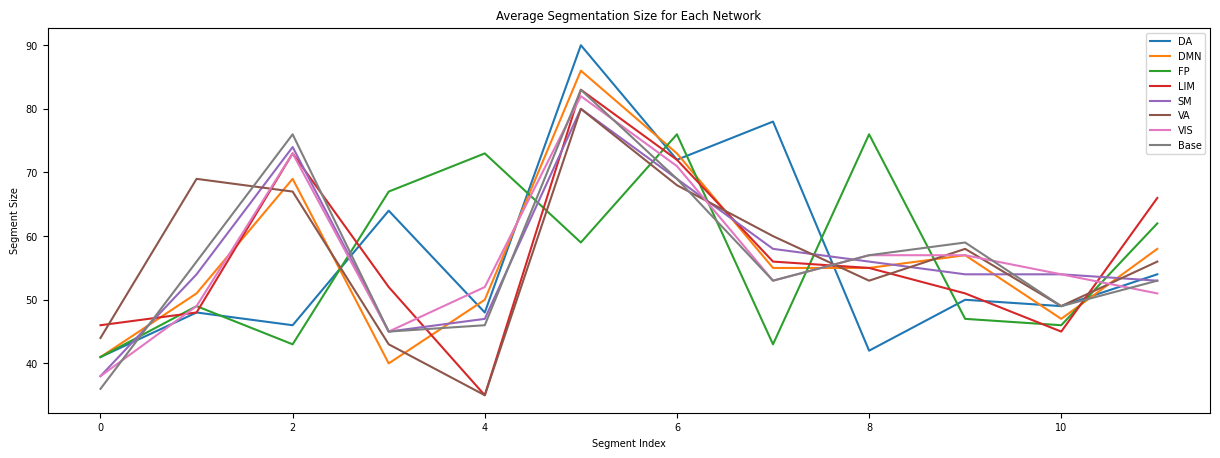

In [86]:
# first just plot the average boundary size for each network

# plot the average boundary size for each network and the base ESN in one plot
fig = plt.figure(figsize=(15, 5))

for network in res_states:
    plt.plot(np.diff(bounds_per_network[network]), label=network)
plt.title('Average Segmentation Size for Each Network')
plt.xlabel('Segment Index')
plt.ylabel('Segment Size')
plt.legend()
plt.show()

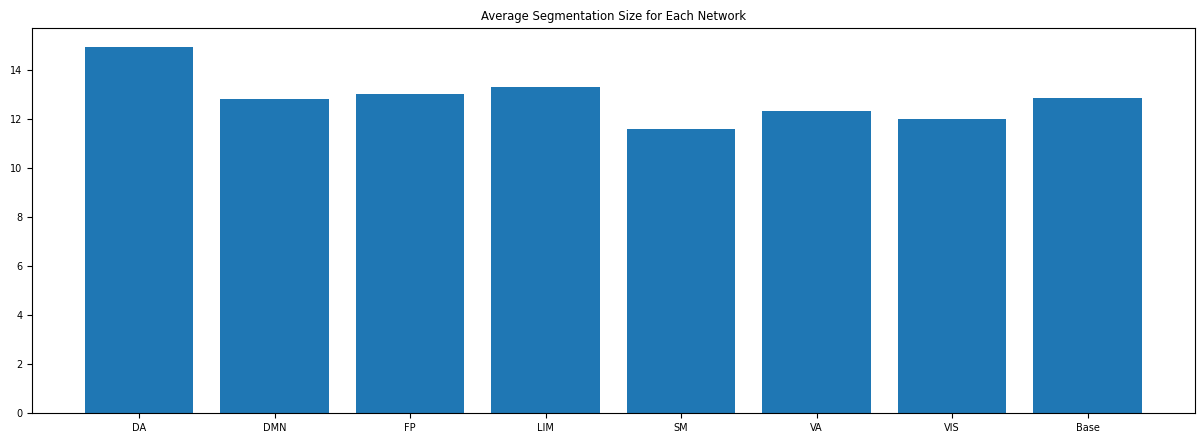

In [114]:
# now a bar plot of the average boundary size for each network and the base ESN

fig = plt.figure(figsize=(15, 5))

boundary_sizes = []
for network in bounds_per_network:
    boundary_sizes.append(np.std(np.diff(bounds_per_network[network])))
plt.bar(list(bounds_per_network.keys()), boundary_sizes)
plt.title('Average Segmentation Size Variation for Each Network')
# add bars for standard deviation
# plt.errorbar(networks, boundary_sizes, yerr=[np.std(np.diff(bounds_per_network[network])) for network in bounds_per_network] + [np.std(np.diff(bounds_aug))], fmt='none', color='black')
plt.show()